# Vehicle Loan Default

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install dask
# !pip install matplotlib
# !pip install statsmodels
# !pip install seaborn
# !pip install sklearn
# !pip install --upgrade scipy
# !pip install xgboost

# Load Packages

In [2]:
import numpy as np
import pandas as pd
import re
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import os
import random
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from sklearn.metrics import roc_auc_score

random.seed(82122)

%matplotlib inline

# Read in Data

In [3]:
cwd = os.getcwd()

inputdir = "C:\\devl\\VehicleLoanDefault\\data"
outputdir = "C:\\devl\\VehicleLoanDefault\\output"

dat = pd.read_csv(inputdir + "\\train.csv", na_values = '?')#, nrows = 10000)
dat.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [4]:
print(dat.shape)
print(dat.dtypes)


(233154, 41)
UniqueID                                 int64
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                                int64
supplier_id                              int64
manufacturer_id                          int64
Current_pincode_ID                       int64
Date.of.Birth                           object
Employment.Type                         object
DisbursalDate                           object
State_ID                                 int64
Employee_code_ID                         int64
MobileNo_Avl_Flag                        int64
Aadhar_flag                              int64
PAN_flag                                 int64
VoterID_flag                             int64
Driving_flag                             int64
Passport_flag                            int64
PERFORM_CNS.SCORE                        int64
PERFORM_CNS.SCORE.DESCRIPTION           object


In [5]:
dat['loan_default'].mean()

0.2170711203753742

## Fit basic model using age, ltv, employment type, and bureau score

### Age

In [6]:
def dateStringFix(s):
    if (int(s[-2:]) <= 22):
        out = s[0:-2] + '20' + s[-2:]
    else:
        out = s[0:-2] + '19' + s[-2:]
    return(out)

dat['Date.of.Birth'] = [dateStringFix(x) for x in dat['Date.of.Birth']]

In [7]:
dat.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-1977,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [8]:
# Verify the birthdates in year 2000 mapped correctly
dat.iloc[[x for x in range(len(dat['Date.of.Birth'])) if int(dat['Date.of.Birth'][x][-4:-2]) == 20],:]

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
874,562770,56013,80906,71.69,11,24654,49,5940,16-07-2000,NaN,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1300,629054,46952,63872,75.15,20,14158,45,6207,05-03-2000,NaN,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
1864,545303,65282,80109,83.64,63,17066,86,7124,01-01-2000,NaN,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1872,510327,73217,106503,70.33,63,17066,86,7094,18-08-2000,NaN,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1874,465541,56713,65223,89.23,63,17066,86,7106,01-01-2000,NaN,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228371,646804,67882,81461,84.70,17,16471,51,3222,20-03-2000,NaN,...,0,0,11352,0,0,0,3yrs 6mon,7yrs 1mon,0,0
228530,633323,96990,176150,55.92,11,23409,48,6024,11-02-2000,NaN,...,0,0,2712,0,0,0,2yrs 5mon,2yrs 5mon,0,0
228534,611152,75251,104800,73.00,11,23409,48,5966,02-09-2000,NaN,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
230358,623721,62347,74651,84.93,105,22874,86,1294,22-06-2000,NaN,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [9]:
# Convert DOB to Age
dat['Date.of.Birth'] = pd.to_datetime(dat['Date.of.Birth'], format='%d-%m-%Y')

# fix "now" to make code reproducible for others
now = pd.to_datetime(['2022-09-11'])
                   
dat['Age'] = [(now - x).days[0]/365.25 for x in dat['Date.of.Birth'] ]
dat.head()


,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Age
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,38.694045
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,...,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,37.114305
2,417566,53278,61360,89.63,67,22807,45,1497,1985-08-24,Self employed,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,37.048597
3,624493,57513,66113,88.48,67,22807,45,1501,1993-12-30,Self employed,...,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1,28.698152
4,539055,52378,60300,88.39,67,22807,45,1495,1977-12-09,Self employed,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1,44.755647


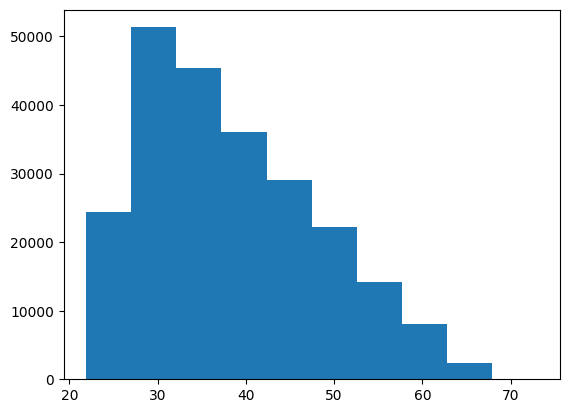

In [10]:
plt.hist(dat['Age'])
plt.show() 

### LTV (Loan-to-Value)

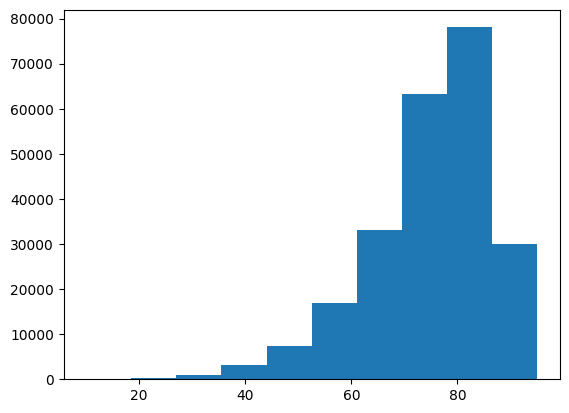

In [11]:
plt.hist(dat['ltv'])
plt.show()

### Employment Type

<AxesSubplot:>

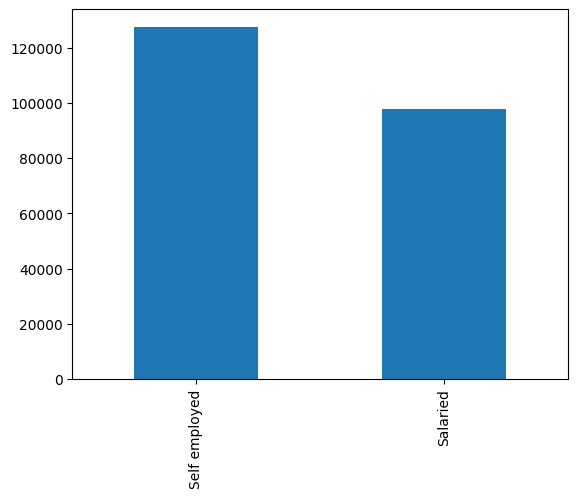

In [12]:
dat['Employment.Type'].value_counts().plot(kind='bar')

In [13]:
print(dat.groupby(['Employment.Type'])['Employment.Type'].count())
print(len(dat[dat['Employment.Type'].isnull()]))

Employment.Type
Salaried          97858
Self employed    127635
Name: Employment.Type, dtype: int64
7661


In [14]:
# Treat missing values as another level for one-hot encoding
dat['Employment.Type'].fillna('missing', inplace = True)
dat.groupby(['Employment.Type'])['Employment.Type'].count()

Employment.Type
Salaried          97858
Self employed    127635
missing            7661
Name: Employment.Type, dtype: int64

In [15]:
# One hot encoding
preds_categorical = ['Employment.Type']

dat = pd.get_dummies(dat, columns = preds_categorical)

### Bureau Score

(array([129785.,      0.,      0.,  10010.,   4292.,   4545.,  13155.,
         26251.,  30743.,  14373.]),
 array([  0.,  89., 178., 267., 356., 445., 534., 623., 712., 801., 890.]),
 <BarContainer object of 10 artists>)

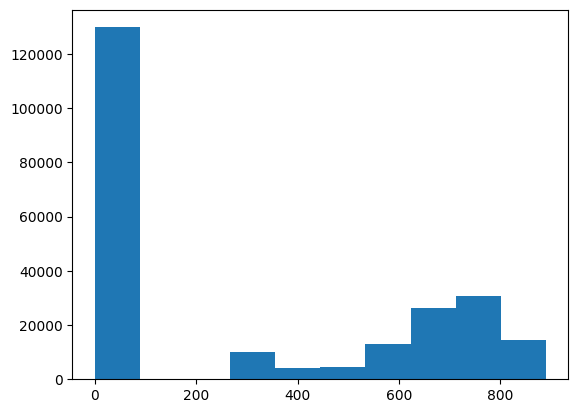

In [16]:
# many scores are missing
plt.hist(dat['PERFORM_CNS.SCORE'])

In [17]:
# I like this variable better because the missing category gets more granular-- we will target encode it and make use of it.
# Need to make train / test splits before exploring this

print(dat.groupby(['PERFORM_CNS.SCORE.DESCRIPTION'])['PERFORM_CNS.SCORE.DESCRIPTION'].count())
print(len(dat[dat['PERFORM_CNS.SCORE.DESCRIPTION'].isnull()]))

PERFORM_CNS.SCORE.DESCRIPTION
A-Very Low Risk                                             14124
B-Very Low Risk                                              9201
C-Very Low Risk                                             16045
D-Very Low Risk                                             11358
E-Low Risk                                                   5821
F-Low Risk                                                   8485
G-Low Risk                                                   3988
H-Medium Risk                                                6855
I-Medium Risk                                                5557
J-High Risk                                                  3748
K-High Risk                                                  8277
L-Very High Risk                                             1134
M-Very High Risk                                             8776
No Bureau History Available                                116950
Not Scored: More than 50 active Accounts found

In [18]:
# Send all Not Scored to the same level
idx = [i for i in range(len(dat['PERFORM_CNS.SCORE.DESCRIPTION'])) if 'Not Scored' in dat['PERFORM_CNS.SCORE.DESCRIPTION'][i]]
dat.loc[idx, 'PERFORM_CNS.SCORE.DESCRIPTION'] = 'Not Scored'
print(dat.groupby(['PERFORM_CNS.SCORE.DESCRIPTION'])['PERFORM_CNS.SCORE.DESCRIPTION'].count())

PERFORM_CNS.SCORE.DESCRIPTION
A-Very Low Risk                 14124
B-Very Low Risk                  9201
C-Very Low Risk                 16045
D-Very Low Risk                 11358
E-Low Risk                       5821
F-Low Risk                       8485
G-Low Risk                       3988
H-Medium Risk                    6855
I-Medium Risk                    5557
J-High Risk                      3748
K-High Risk                      8277
L-Very High Risk                 1134
M-Very High Risk                 8776
No Bureau History Available    116950
Not Scored                      12835
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64


## Train / Test Splits, Standardization, and Target Encoding

In [19]:
print(dat.dtypes)

UniqueID                                        int64
disbursed_amount                                int64
asset_cost                                      int64
ltv                                           float64
branch_id                                       int64
supplier_id                                     int64
manufacturer_id                                 int64
Current_pincode_ID                              int64
Date.of.Birth                          datetime64[ns]
DisbursalDate                                  object
State_ID                                        int64
Employee_code_ID                                int64
MobileNo_Avl_Flag                               int64
Aadhar_flag                                     int64
PAN_flag                                        int64
VoterID_flag                                    int64
Driving_flag                                    int64
Passport_flag                                   int64
PERFORM_CNS.SCORE           

In [20]:
cols_categorical = ['Employment.Type_Salaried'
                    , 'Employment.Type_Self employed'
                    , 'Employment.Type_missing'
                    , 'PERFORM_CNS.SCORE.DESCRIPTION']

cols_numeric = ['ltv'
               , 'Age']


## Train/Test splits, stratifying on default occurrence

Use 60/20/20 split, where 60% is used for cross-validation/parameter tuning, 20% used for model comparisons and benchmarking, and 20% used for final holdout testing.

Stratify on default occurrence to ensure adequate number of defaults appearing in each set.

In [21]:
dat_train = dat.sample(frac = .60)
dat_test = dat.drop(dat_train.index)
dat_holdout = dat_test.sample(frac = .5)
dat_test = dat_test.drop(dat_holdout.index)

print(dat_train.shape
     , dat_test.shape
     , dat_holdout.shape)

(139892, 44) (46631, 44) (46631, 44)


In [22]:
# Target encode credit variable
# We see some nice separation in the default rates
target_map = dat_train.groupby('PERFORM_CNS.SCORE.DESCRIPTION').mean()[['loan_default']].to_dict()
print(target_map)
# print(dat_train.groupby(['PERFORM_CNS.SCORE.DESCRIPTION'])['PERFORM_CNS.SCORE.DESCRIPTION'].count())


{'loan_default': {'A-Very Low Risk': 0.16394021419324467, 'B-Very Low Risk': 0.12695868945868946, 'C-Very Low Risk': 0.17230898228697203, 'D-Very Low Risk': 0.14835246757119427, 'E-Low Risk': 0.16789146410401357, 'F-Low Risk': 0.18967894425842033, 'G-Low Risk': 0.20337552742616033, 'H-Medium Risk': 0.24536235468711354, 'I-Medium Risk': 0.2670807453416149, 'J-High Risk': 0.2505513895015439, 'K-High Risk': 0.27414141414141413, 'L-Very High Risk': 0.2691131498470948, 'M-Very High Risk': 0.30194743807903196, 'No Bureau History Available': 0.22988374905732864, 'Not Scored': 0.2103345047507484}}


In [23]:
dat_train['CNS.SCORE' + '_tgt'] = dat_train.loc[:,'PERFORM_CNS.SCORE.DESCRIPTION'].map(target_map['loan_default'])
dat_test['CNS.SCORE' + '_tgt'] = dat_test.loc[:,'PERFORM_CNS.SCORE.DESCRIPTION'].map(target_map['loan_default'])
dat_holdout['CNS.SCORE' + '_tgt'] = dat_holdout.loc[:,'PERFORM_CNS.SCORE.DESCRIPTION'].map(target_map['loan_default'])

In [24]:
cols_categorical = ['Employment.Type_Salaried'
                    , 'Employment.Type_Self employed'
                    , 'Employment.Type_missing']

cols_numeric = ['ltv'
               , 'Age'
               , 'CNS.SCORE_tgt']


In [25]:
dat_train = dat_train[cols_numeric + cols_categorical + ['loan_default']].copy()
dat_test = dat_test[cols_numeric + cols_categorical + ['loan_default']].copy()
dat_holdout = dat_holdout[cols_numeric + cols_categorical + ['loan_default']].copy()


In [26]:
# Check default incidence rate stratification
print(dat_train['loan_default'].mean(), dat_test['loan_default'].mean(), dat_holdout['loan_default'].mean())

0.21551625539702055 0.21985374536252708 0.21895305697926273


# Model Fitting

In [27]:
# Set up folds within training set
n_folds = 5 
folds = np.repeat(np.arange(1, n_folds + 1), len(dat_train)//n_folds)
folds = np.append(folds, np.repeat(n_folds, len(dat_train) - len(folds)))

random.shuffle(folds)

dat_train['FOLD'] = folds
dat_train.head()

,ltv,Age,CNS.SCORE_tgt,Employment.Type_Salaried,Employment.Type_Self employed,Employment.Type_missing,loan_default,FOLD
196983,74.69,26.694045,0.229884,0,1,0,1,1
215566,77.32,30.286105,0.229884,0,1,0,1,2
63815,79.86,65.691992,0.126959,0,1,0,0,1
137019,74.73,36.848734,0.301947,1,0,0,1,1
56371,74.45,36.711841,0.229884,0,1,0,0,4


In [28]:
# check default rate stratification on folds. Random sampling does a great job here.
print(dat_train.groupby(['FOLD'])['loan_default'].mean())

FOLD
1    0.217457
2    0.212596
3    0.216063
4    0.216706
5    0.214761
Name: loan_default, dtype: float64


In [41]:
X.columns

Index(['ltv', 'Age', 'CNS.SCORE_tgt', 'Employment.Type_Salaried',
       'Employment.Type_Self employed', 'Employment.Type_missing'],
      dtype='object')

In [42]:
y = dat_train[['loan_default', 'FOLD']]
X = dat_train.drop(['FOLD'], axis = 1)

In [ ]:
# for fold in range(1,6):
#     X = train_dat[train_dat['FOLD'] != fold].drop(['FOLD'], axis = 1)
#     y = train_dat[train_dat['FOLD'] != fold].drop(['FOLD'], axis = 1)